In [1]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
import tensorflow as tf
from tqdm import tqdm
import glob

%matplotlib inline

Using TensorFlow backend.


(31, 2)

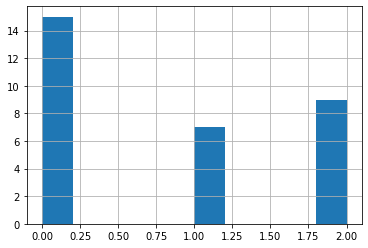

In [2]:
np.random.seed(2019)

files=glob.glob("./images/ok/*")
dfok=pd.DataFrame(files,columns=["id_code"])
dfok["diagnosis"]=0
dfok.shape

files=glob.glob("./images/bad/*")
dfbad=pd.DataFrame(files,columns=["id_code"])
dfbad["diagnosis"]=1
dfbad.shape


files=glob.glob("./images/ng/*")
dfng=pd.DataFrame(files,columns=["id_code"])
dfng["diagnosis"]=2
dfng.shape


dfall=pd.concat([dfok,dfbad,dfng])
dfall.shape

dfall['diagnosis'].hist()
dfall['diagnosis'].value_counts()
dfall.shape

In [3]:
from sklearn.model_selection import train_test_split

train_df, test_df=train_test_split(dfall,test_size=0.20,shuffle=True)
train_df.shape

def get_pad_width(im, new_shape, is_rgb=True):
    pad_diff = new_shape - im.shape[0], new_shape - im.shape[1]
    t, b = math.floor(pad_diff[0]/2), math.ceil(pad_diff[0]/2)
    l, r = math.floor(pad_diff[1]/2), math.ceil(pad_diff[1]/2)
    if is_rgb:
        pad_width = ((t,b), (l,r), (0, 0))
    else:
        pad_width = ((t,b), (l,r))
    return pad_width

def preprocess_image(image_path, desired_size=32):
    im = Image.open(image_path)
    im = im.resize((desired_size, )*2, resample=Image.LANCZOS)
    
    return im


In [4]:
N = train_df.shape[0]
x_train = np.empty((N, 32, 32, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(train_df['id_code'])):
    x_train[i, :, :, :] = preprocess_image(image_id)
x_train.shape

N = test_df.shape[0]
x_test = np.empty((N, 32, 32, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(test_df['id_code'])):
    x_test[i, :, :, :] = preprocess_image(image_id)


y_train = pd.get_dummies(train_df['diagnosis']).values

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)

y_train_multi = np.empty(y_train.shape, dtype=y_train.dtype)
y_train_multi[:, 2] = y_train[:, 2]

for i in range(2):
    y_train_multi[:, i] = np.logical_or(y_train[:, i], y_train_multi[:, i+1])

print("Original y_train:", y_train.sum(axis=0))
print("Multilabel version:", y_train_multi.sum(axis=0))

x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train_multi, 
    test_size=0.15, 
    random_state=2019,shuffle=True
)


100%|██████████| 7/7 [00:00<00:00, 79.34it/s]

(24, 32, 32, 3)
(24, 3)
(7, 32, 32, 3)
Original y_train: [11  6  7]
Multilabel version: [11 13  7]


In [5]:

class MixupGenerator():
    def __init__(self, X_train, y_train, batch_size=32, alpha=0.2, shuffle=True, datagen=None):
        self.X_train = X_train
        self.y_train = y_train
        self.batch_size = batch_size
        self.alpha = alpha
        self.shuffle = shuffle
        self.sample_num = len(X_train)
        self.datagen = datagen

    def __call__(self):
        while True:
            indexes = self.__get_exploration_order()
            itr_num = int(len(indexes) // (self.batch_size * 2))

            for i in range(itr_num):
                batch_ids = indexes[i * self.batch_size * 2:(i + 1) * self.batch_size * 2]
                X, y = self.__data_generation(batch_ids)

                yield X, y

    def __get_exploration_order(self):
        indexes = np.arange(self.sample_num)

        if self.shuffle:
            np.random.shuffle(indexes)

        return indexes

    def __data_generation(self, batch_ids):
        _, h, w, c = self.X_train.shape
        l = np.random.beta(self.alpha, self.alpha, self.batch_size)
        X_l = l.reshape(self.batch_size, 1, 1, 1)
        y_l = l.reshape(self.batch_size, 1)

        X1 = self.X_train[batch_ids[:self.batch_size]]
        X2 = self.X_train[batch_ids[self.batch_size:]]
        X = X1 * X_l + X2 * (1 - X_l)

        if self.datagen:
            for i in range(self.batch_size):
                X[i] = self.datagen.random_transform(X[i])
                X[i] = self.datagen.standardize(X[i])

        if isinstance(self.y_train, list):
            y = []

            for y_train_ in self.y_train:
                y1 = y_train_[batch_ids[:self.batch_size]]
                y2 = y_train_[batch_ids[self.batch_size:]]
                y.append(y1 * y_l + y2 * (1 - y_l))
        else:
            y1 = self.y_train[batch_ids[:self.batch_size]]
            y2 = self.y_train[batch_ids[self.batch_size:]]
            y = y1 * y_l + y2 * (1 - y_l)

        return X, y


In [6]:
BATCH_SIZE = 1

def create_datagen():
    return ImageDataGenerator(
        zoom_range=0.15,  # set range for random zoom
        # set mode for filling points outside the input boundaries
        fill_mode='constant',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

# Using original generator
data_generator = create_datagen().flow(x_train, y_train, batch_size=BATCH_SIZE, seed=2019)
# Using Mixup
mixup_generator = MixupGenerator(x_train, y_train, batch_size=BATCH_SIZE, alpha=0.2, datagen=create_datagen())()

In [7]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.validation_data[:2]
        y_val = y_val.sum(axis=1) - 1
        
        y_pred = self.model.predict(X_val) > 0.5
        y_pred = y_pred.astype(int).sum(axis=1) - 1

        _val_kappa = cohen_kappa_score(
            y_val,
            y_pred, 
            weights='quadratic'
        )

        self.val_kappas.append(_val_kappa)

        print(f"val_kappa: {_val_kappa:.4f}")
        
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save('model.h5')

        return

densenet = DenseNet121(
    weights="imagenet",
    include_top=False,
    input_shape=(32,32,3)
)

def build_model():
    model = Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(3, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=0.00005),
        metrics=['accuracy']
    )
    
    return model

In [8]:

model = build_model()
model.summary()

kappa_metrics = Metrics()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 1, 1, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3075      
Total params: 7,040,579
Trainable params: 6,956,931
Non-trainable params: 83,648
_________________________________________________________________


In [9]:
history = model.fit_generator(
    data_generator,
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=50,
    validation_data=(x_val, y_val),
    callbacks=[kappa_metrics])

Epoch 1/50
20/20 [==============================] - 201s 10s/step - loss: 0.7809 - accuracy: 0.5167 - val_loss: 1.2375 - val_accuracy: 0.3333
val_kappa: 0.2000
Validation Kappa has improved. Saving model.
Epoch 2/50
20/20 [==============================] - 20s 1s/step - loss: 0.8077 - accuracy: 0.4167 - val_loss: 1.1190 - val_accuracy: 0.5833
val_kappa: 0.6667
Validation Kappa has improved. Saving model.
Epoch 3/50
20/20 [==============================] - 14s 690ms/step - loss: 0.7706 - accuracy: 0.4333 - val_loss: 1.1706 - val_accuracy: 0.5000
val_kappa: 0.4286
Epoch 4/50
20/20 [==============================] - 13s 637ms/step - loss: 0.7277 - accuracy: 0.5333 - val_loss: 1.1549 - val_accuracy: 0.5833
val_kappa: -0.2500
Epoch 5/50
20/20 [==============================] - 12s 618ms/step - loss: 0.7636 - accuracy: 0.4167 - val_loss: 1.2762 - val_accuracy: 0.5833
val_kappa: -0.2500
Epoch 6/50
20/20 [==============================] - 13s 655ms/step - loss: 0.7211 - accuracy: 0.5167 - val_

KeyboardInterrupt: 

In [ ]:
# with open('history.json', 'w') as f:
#     json.dump(history.history, f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()

plt.plot(kappa_metrics.val_kappas)

In [11]:


model.load_weights('model.h5')
y_val_pred = model.predict(x_val)

In [12]:
def compute_score_inv(threshold):
    y1 = y_val_pred > threshold
    y1 = y1.astype(int).sum(axis=1) - 1
    y2 = y_val.sum(axis=1) - 1
    score = cohen_kappa_score(y1, y2, weights='quadratic')
    
    return 1 - score

simplex = scipy.optimize.minimize(
    compute_score_inv, 0.5, method='nelder-mead'
)

best_threshold = simplex['x'][0]

y_test = model.predict(x_test) > 0.5
y_test = y_test.astype(int).sum(axis=1) - 1

test_df['prediction'] = y_test
test_df.to_csv('submission.csv',index=False)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [13]:
test_df

,id_code,diagnosis,prediction
3,./images/ok/EatPvLGU4AAr6Ul.jpeg,0,2
2,./images/bad/images.jpeg,1,1
11,./images/ok/img_79becab66f844a12aa281ba8b4d6fe...,0,0
9,./images/ok/AB58495B41F54671B17910C6E88A2754_L...,0,1
3,./images/ng/images (1).jpeg,2,1
4,./images/ng/CKKwGvQVAAANkTk.jpeg,2,1
13,./images/ok/DSC_0306.jpg,0,1


In [14]:
prediction=test_df.prediction
id=test_df.id_code

In [15]:
prediction

3     2
2     1
11    0
9     1
3     1
4     1
13    1
Name: prediction, dtype: int64

川が氾濫しています。絶対に川辺には降りないでください
川の水位が上がっていますので十分注意してください。
今日の川の水域は安全です。
川の水位が上がっていますので十分注意してください。
川の水位が上がっていますので十分注意してください。
川の水位が上がっていますので十分注意してください。
川の水位が上がっていますので十分注意してください。


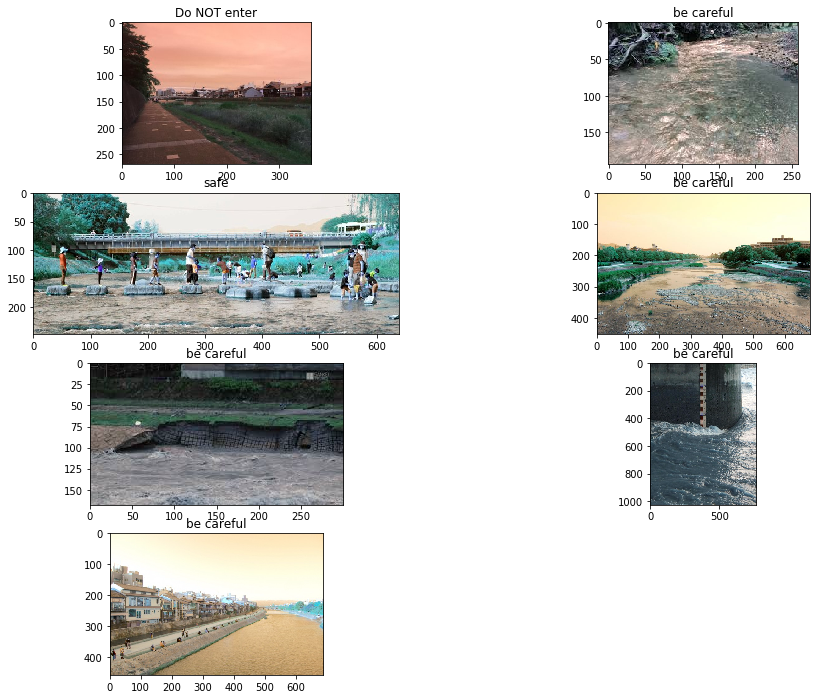

In [18]:
%matplotlib inline
plt.figure(figsize=(16,12))

for num,i  in enumerate(zip(prediction,id)):
    plt.subplot(4,2,num+1)
    if i[0] == 0 :
        print("今日の川の水域は安全です。")
        image=cv2.imread(i[1],1)
        plt.title("safe")
#         plt.title(i[1])
        plt.imshow(image)
    elif i[0] ==1 :
        print("川の水位が上がっていますので十分注意してください。")
        image=cv2.imread(i[1],1)
#         plt.title(i[1])
        plt.title("be careful")
        plt.imshow(image)
    else :
        print("川が氾濫しています。絶対に川辺には降りないでください")
        image=cv2.imread(i[1],1)
#         plt.title(i[1])
        plt.title("Do NOT enter")
        plt.imshow(image)